### Imports

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from motornet.effector import RigidTendonArm26
from motornet.muscle import MujocoHillMuscle
from motornet import plotor  # for arm plotting

# make plots look a bit nicer
%matplotlib inline

### Arm26 Initialization

In [2]:
# build the arm26 effector: TwoDofArm skeleton + 6 MujocoHillMuscle actuators
effector = RigidTendonArm26(muscle=MujocoHillMuscle())

print("dt:", effector.dt)
print("n_muscles:", effector.n_muscles)
print("DOFs:", effector.skeleton.dof)

dt: 0.01
n_muscles: 6
DOFs: 2


### Inspect state names + initial states (batch_size = 7)

In [3]:
effector.reset(options={"batch_size": 7}) # reset default is batch_size = 1

# State names
print("State dict keys:", effector.states.keys(), "\n")

# State sizes
for key, state in effector.states.items():
  print(key + " shape: " + " " * (10-len(key)), state.shape)


joint_state = effector.states["joint"] # torch.Size([7, 4]) => batch_size, positions and velocities :
# joint_state[:, 0] = shoulder_pos
# joint_state[:, 1] = elbow_pos
# joint_state[:, 2] = shoulder_vel
# joint_state[:, 3] = elbow_vel

cartesian_state = effector.states["cartesian"] # torch.Size([7, 4]) => same as joint but convered to cartesian form

muscle_state = effector.states["muscle"] # torch.Size([7, 7, 6]) => batch_size, features, muscles
print("\nmuscle states :", effector.muscle.state_name)
print("muscle names (arm26):", effector.muscle_name) # the 6 arm26 muscles

geometry_state = effector.states["geometry"] # torch.Size([7, 4, 6]) => batch_size, features, muscles
# geometry_state[:, 0, :] = musculotendon_length
# geometry_state[:, 1, :] = musculotendon_velocity
# geometry_state[:, 2, :] = sholder_moment_arm
# geometry_state[:, 3, :] = elbow_moment_arm

fingertip_state = effector.states["fingertip"] # torch.Size([7, 2]) => batch_size, x,y coordinates

State dict keys: dict_keys(['joint', 'cartesian', 'muscle', 'geometry', 'fingertip']) 

joint shape:       torch.Size([7, 4])
cartesian shape:   torch.Size([7, 4])
muscle shape:      torch.Size([7, 7, 6])
geometry shape:    torch.Size([7, 4, 6])
fingertip shape:   torch.Size([7, 2])

muscle states : ['activation', 'muscle length', 'muscle velocity', 'force-length PE', 'force-length CE', 'force-velocity CE', 'force']
muscle names (arm26): ['pectoralis', 'deltoid', 'brachioradialis', 'tricepslat', 'biceps', 'tricepslong']


In [4]:
print("\nexample joint states (radians):\n", joint_state)

print("\njoint states for all arms (radians) beautiful print:")
for i, joint in enumerate(joint_state):
    shoulder_pos = joint[0].item()
    elbow_pos    = joint[1].item()
    shoulder_vel = joint[2].item()
    elbow_vel    = joint[3].item()

    print(f"arm {i}: "
          f"shoulder_pos={shoulder_pos:.4f}, "
          f"elbow_pos={elbow_pos:.4f}") # velocities are all 0 so I didn't print them

print("\nexample fingertip positions (first 3 arms):\n", fingertip_state[:3])

# convert first arm's joint angles to degrees for readability
import math
print("\nfirst arm angles in degrees:")
print("  shoulder:", math.degrees(joint_state[0, 0].item()))
print("  elbow   :", math.degrees(joint_state[0, 1].item()))

print("\njoint states in degrees:")
for i, joint in enumerate(joint_state):
    sh_deg = math.degrees(joint[0].item())
    el_deg = math.degrees(joint[1].item())
    print(f"arm {i}: shoulder={sh_deg:7.2f}°, elbow={el_deg:7.2f}°")




example joint states (radians):
 tensor([[1.4275, 1.1008, 0.0000, 0.0000],
        [0.9877, 1.3475, 0.0000, 0.0000],
        [0.8859, 0.2373, 0.0000, 0.0000],
        [2.2697, 0.6051, 0.0000, 0.0000],
        [0.4044, 1.1030, 0.0000, 0.0000],
        [0.7247, 1.5266, 0.0000, 0.0000],
        [0.5072, 1.4438, 0.0000, 0.0000]])

joint states for all arms (radians) beautiful print:
arm 0: shoulder_pos=1.4275, elbow_pos=1.1008
arm 1: shoulder_pos=0.9877, elbow_pos=1.3475
arm 2: shoulder_pos=0.8859, elbow_pos=0.2373
arm 3: shoulder_pos=2.2697, elbow_pos=0.6051
arm 4: shoulder_pos=0.4044, elbow_pos=1.1030
arm 5: shoulder_pos=0.7247, elbow_pos=1.5266
arm 6: shoulder_pos=0.5072, elbow_pos=1.4438

example fingertip positions (first 3 arms):
 tensor([[-0.2282,  0.4975],
        [-0.0603,  0.4983],
        [ 0.3396,  0.5395]])

first arm angles in degrees:
  shoulder: 81.79182266941534
  elbow   : 63.0714352865693

joint states in degrees:
arm 0: shoulder=  81.79°, elbow=  63.07°
arm 1: shoulder

### Running a short simulation and recording muscle activity

In [5]:
# freash reset
effector.reset(options={"batch_size": 1}) # one arm

'''# example with fixed initial joint state: shoulder = 0 rad, elbow = 0 rad
initial_joint = torch.tensor([[0.0, 0.0, 0.0, 0.0]])  # [pos_sh, pos_el, vel_sh, vel_el]

effector.reset(options={"joint_state": initial_joint})'''

T = 300  # number of timesteps
state_dim = effector.muscle.state_dim # 7
n_muscles = effector.n_muscles

# to record muscle_state over time: [T, state_dim, n_muscles]
muscle_traj = torch.zeros((T, state_dim, n_muscles))

# chose one muscle to inspect ('biceps')
print("muscle names:", effector.muscle_name)
muscle_idx = effector.muscle_name.index("biceps")

for t in range(T): # each iteration corresponds to one physical time step of length effector.dt seconds (0.01 s)
    activation_level = t / (T - 1) # activation pattern: ramp activation from 0 to 1 in the chosen muscle
    action = torch.zeros((1, n_muscles)) # action shape [batch_size, n_muscles]
    action[0, muscle_idx] = activation_level

    effector.step(action)
    # effector.states["muscle"] has shape [batch, state_dim, n_muscles]
    muscle_traj[t] = effector.states["muscle"][0]  # taking batch 0; has shape [7, 6]
    # after the loop, muscle_traj contains the full time course of all internal muscle variables for all 6 muscles.

muscle_traj_np = muscle_traj.detach().cpu().numpy()


muscle names: ['pectoralis', 'deltoid', 'brachioradialis', 'tricepslat', 'biceps', 'tricepslong']


### Plot muscle activation, length, velocity, force

Muscle state names: ['activation', 'muscle length', 'muscle velocity', 'force-length PE', 'force-length CE', 'force-velocity CE', 'force']


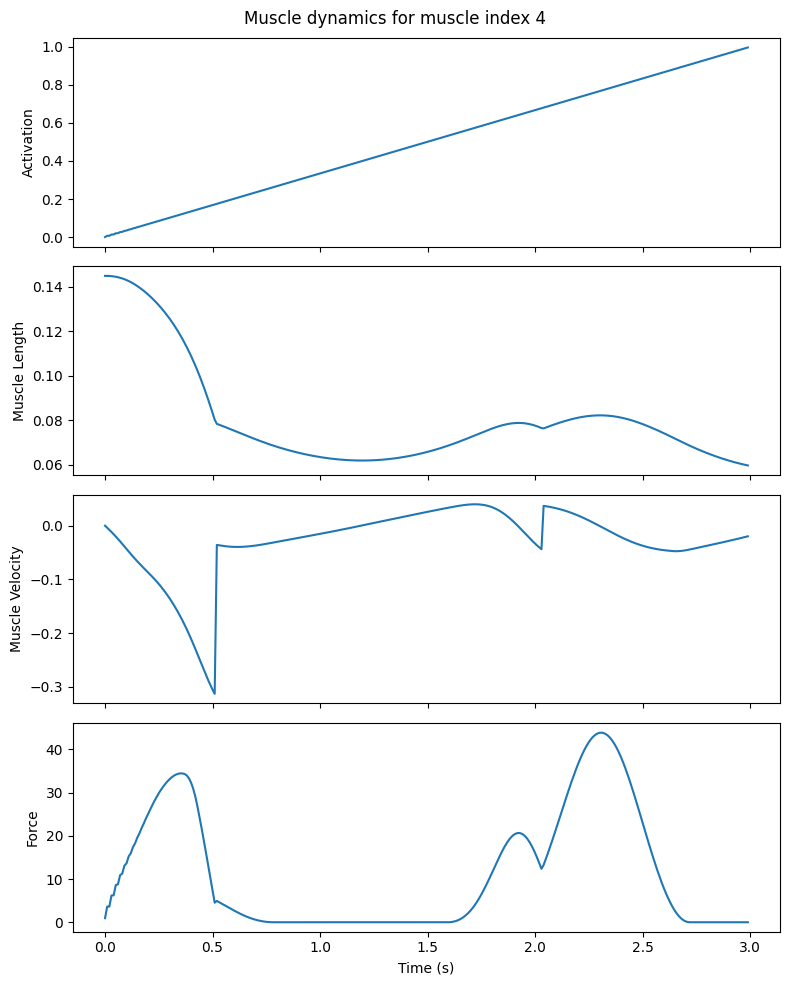

In [6]:
time = np.arange(T) * effector.dt  # seconds

state_names = effector.muscle.state_name
print("Muscle state names:", state_names)

# helper to find index of a given state by name
def idx(name):
    return state_names.index(name)

act_idx   = idx("activation")
len_idx   = idx("muscle length")
vel_idx   = idx("muscle velocity")
force_idx = idx("force")  # total force term

fig, axes = plt.subplots(4, 1, figsize=(8, 10), sharex=True)

axes[0].plot(time, muscle_traj_np[:, act_idx, muscle_idx])
axes[0].set_ylabel("Activation")

axes[1].plot(time, muscle_traj_np[:, len_idx, muscle_idx])
axes[1].set_ylabel("Muscle Length")

axes[2].plot(time, muscle_traj_np[:, vel_idx, muscle_idx])
axes[2].set_ylabel("Muscle Velocity")

axes[3].plot(time, muscle_traj_np[:, force_idx, muscle_idx])
axes[3].set_ylabel("Force")
axes[3].set_xlabel("Time (s)")

fig.suptitle(f"Muscle dynamics for muscle index {muscle_idx}")
plt.tight_layout()
plt.show()


### Passive Drift

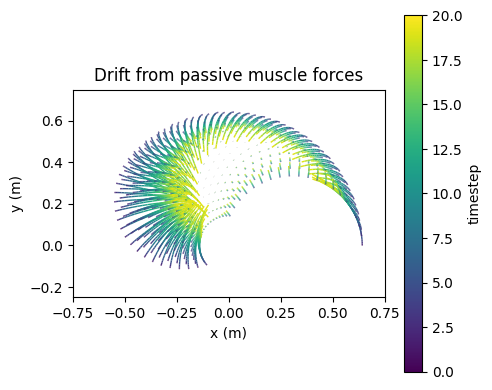

In [7]:

dt = effector.dt
n_muscles = effector.n_muscles


# making a mesh grid

n_states = 21  # 21x21 grid

sho_vals = np.linspace(effector.pos_lower_bound[0], effector.pos_upper_bound[0], n_states).astype('float32')
elb_vals = np.linspace(effector.pos_lower_bound[1], effector.pos_upper_bound[1], n_states).astype('float32')

sho, elb = np.meshgrid(sho_vals, elb_vals)  # shape [21, 21] each
sho_t = torch.tensor(sho)
elb_t = torch.tensor(elb)

# zero activation for all muscles and all grid points
n_grid = sho_t.numel()  # 21*21
action = torch.zeros((n_grid, n_muscles))

# reset effector: 1 arm per grid point, velocities = 0
joint_positions = torch.stack([sho_t.reshape(-1), elb_t.reshape(-1)], dim=1)  # [441, 2]
effector.reset(options={"joint_state": joint_positions})

# fingertip positions over time
fingertips = effector.states["fingertip"][:, None, :]  # [441, 1, 2]

T_drift = int(0.2 / dt)  # 200 ms

for _ in range(T_drift):
    effector.step(action)
    fingertip = effector.states["fingertip"][:, None, :]  # [441, 1, 2]
    fingertips = torch.cat([fingertips, fingertip], dim=1)  # [441, T+1, 2]

fingertips_np = fingertips.detach().cpu().numpy()

# plottinh the drift from passive forces
plt.figure(figsize=(5, 4)).set_tight_layout(True)
plt.ylim([-0.25, 0.75])
plt.xlim([-0.75, 0.75])
plotor.plot_pos_over_time(axis=plt.gca(), cart_results=fingertips_np)
plt.title("Drift from passive muscle forces")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()
